In [3]:
import os
import sys
import numpy as np
import torch

# from pycochleagram.cochleagram import invert_cochleagram
from torchvision import transforms
# from utils import waveFromCochleagram, batchWaveFromCochleagram
from tqdm import tqdm

In [77]:
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import librosa
from librosa.feature import spectral_centroid
from librosa.util import peak_pick
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [152]:
class Evaluator:
    def __init__(self, model, dataloader, num_batches=250):
        self.sr = 96000
        self.model = model
        self.dataloader = dataloader
        self.num_batches = num_batches
        
    def get_metrics(self):
        wavs = []
        gt_wavs = []
        '''
        for i, data in tqdm(enumerate(self.dataloader)):
            coch, stFrames, frame0, material = data
            out = self.model(stFrames, frame0).detach().cpu().numpy() 
            ret = batchWaveFromCochleagram(out)
            wavs.extend(ret)
            print(len(wavs))
            
            if i >= self.num_batches-1:
                break
        '''
        batch_size = 2
        # wavs = np.random.rand(self.num_batches*batch_size, 48000)
        # gt_wavs = np.random.rand(self.num_batches*batch_size, 48000)
        gt_wavs = torch.load("../../data/gt_wavs")
        gt_wavs = gt_wavs.numpy()
        wavs = torch.load("../../data/pred_wavs")
        wavs = wavs.numpy()
        print(wavs.shape)


        print("Reconstructable")
        print(self.reconstructable(wavs))
        print("Reconstruction Loss")
        print(self.reconstruction_loss(wavs, gt_wavs))
        # print("FFT Reconstruction Loss")
        # print(self.fft_reconstruction_loss(wavs, gt_wavs))
        print("Loudness")
        print(self.loudness(wavs, gt_wavs))
        print("Spectral Centroid Difference")
        print(self.spectral_centroid_difference(wavs, gt_wavs))
        print("Peak Displacement")
        print(self.peak_displacement(wavs, gt_wavs))

    def _plot_metric(self, metric_arr, metric=""):
        plt.hist(metric_arr)
        plt.title(f"{metric.capitalize()} Distribution")
        plt.xlabel(metric)
        plt.show()
    
    def _compute_mse(self, y1, y2):
        return np.mean((y1 - y2)**2, axis=1)
    
    def _compute_rmse(self, y1, y2):
        '''standard difference metric for waveforms'''
        return np.sqrt(np.mean((y1 - y2)**2, axis=1))

    def _compute_cosine_similarity(self, y1, y2):
        '''Used between normalized waveforms'''
        dot = np.sum(np.multiply(y1, y2), axis=1)
        norm = np.linalg.norm(y1, axis=1) * np.linalg.norm(y2, axis=1)
        return dot/norm

    def _pearson_correlation_coefficient(self, y1, y2):
        '''Used to show correlation between rising and falling of the waveforms'''
        sample_pcc = []
        for y, _y in zip(y1, y2):
            res = scipy.stats.pearsonr(y, _y)
            sample_pcc.append(res[0])
        
        return np.array(sample_pcc)
            
    def reconstructable(self, wavs):
        not_reconstructable = 0
        for wav in wavs:
            if np.isnan(wav).any():
                not_reconstructable += 1
        print(not_reconstructable, len(wavs))
        return 1 - not_reconstructable/len(wavs)

    def reconstruction_loss(self, wavs, gt_wavs, plot=False):
        '''Uses the RMSE metric for finding difference between 2 waveforms'''
        # Make sure to filter wavs and gt_wavs that cannot be reconstructed before this
        sample_rmse = self._compute_rmse(wavs, gt_wavs)

        if plot:
            self._plot_metric(sample_rmse, "reconstruction loss")

        return np.mean(sample_rmse)

    def fft_reconstruction_loss(self, wavs, gt_wavs, plot=False):
        frequencies, times, spectrograms = signal.spectrogram(wavs, self.sr)
        gt_frequencies, gt_times, gt_spectrograms = signal.spectrogram(gt_wavs, self.sr)
        print(spectrograms.shape)
        sample_spectogram_rmse = self._compute_rmse(spectrograms, gt_spectrograms)

        if plot:
            self._plot_metric(sample_spectogram_rmse, "fft reconstruction loss")

        return np.mean(sample_spectogram_rmse)

    def loudness(self, wavs, gt_wavs, plot=False):
        sample_loudness = self._compute_mse(wavs, gt_wavs)

        if plot:
            self._plot_metric(sample_loudness, "loudness loss")

        return np.mean(sample_loudness)

    def spectral_centroid_difference(self, wavs, gt_wavs, plot=False):
        sample_centroid_difference = []
        for wav, gt_wav in zip(wavs, gt_wavs):
            # for each time_step one spectral centroid, indication of the domininant frequency that can be heard
            wav_centroids = spectral_centroid(y=wav+0.01, sr=self.sr)
            gt_centroids = spectral_centroid(y=gt_wav+0.01, sr=self.sr)
            plt.plot(range(wav_centroids.shape[1]), wav_centroids[0], label="pred")
            plt.plot(range(gt_centroids.shape[1]), gt_centroids[0], label="gt")
            plt.legend()
            plt.show()

            sample_centroid_difference.append(np.mean(self._compute_rmse(wav_centroids, gt_centroids)))
            break
        
        if plot:
            self._plot_metric(sample_centroid_difference, "spectral centroid difference")

        return np.mean(sample_centroid_difference)


    def peak_displacement(self, wavs, gt_wavs, plot=False):
        wavs_peak_pos = np.argmax(wavs, axis=1)
        gt_wavs_peak_pos = np.argmax(gt_wavs, axis=1)
        wavs_peak_pos = np.expand_dims(wavs_peak_pos, axis=-1)
        gt_wavs_peak_pos = np.expand_dims(gt_wavs_peak_pos, axis=-1)
        sample_peak_displacement = self._compute_rmse(wavs_peak_pos, gt_wavs_peak_pos)

        if plot:
            self._plot_metric(sample_peak_displacement, "peak displacement difference")
        
        return np.mean(sample_peak_displacement)

    def sample_inference_time(self, wavs, plot=False):
        pass

    def material_consistency(self, wavs, gt_wavs, plot=False):
        pass

(16, 48000)
Reconstructable
0 16
1.0
Reconstruction Loss
0.015691975
Loudness
0.00028396593
Spectral Centroid Difference


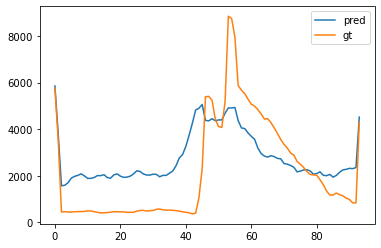

1658.9762963697742
Peak Displacement
58.4375


In [153]:
evaluator = Evaluator(None, None)
evaluator.get_metrics()

In [66]:
y1 = np.array([[1, 2, 3], 
               [3, 2, 1]])
y2 = np.array([[3, 2, 1], 
               [3, 4, 5]])

In [90]:
wavs = np.random.rand(230, 48000)
wavs_onset_envelope = librosa.onset.onset_strength(y=wavs, sr=48000, hop_length=256)
print(wavs_onset_envelope.shape)
wavs_peak_position = librosa.util.peak_pick(x=wavs_onset_envelope[0],
                                            pre_max=7, post_max=7, pre_avg=7, post_avg=7, delta=0.5, wait=5)
print(wavs_peak_position)

(230, 188)
[5]


In [67]:
scipy.stats

(-0.9999999999999998, 1.3415758552508151e-08)